# Set up

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-07 10:23:48.004255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Performing PCA with an Undercomplete Linear Autoencoder

In [2]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2024-04-06 11:17:57.178914: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now, we generate the same 3D dataset we used in chapter 8.

In [3]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.randn(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 + np.random.randn(m, 3)  # add more noises
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=0)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 1ms/step


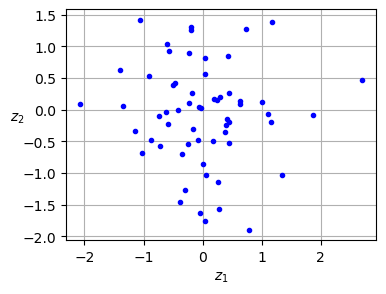

In [5]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid()

## Implementing a Stacked Autoencoder Using Keras

We will use the Fashion MNIST dataset for this problem. 

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [7]:
encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
    ]
)

decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(28 * 28),
        tf.keras.layers.Reshape([28, 28]),
    ]
)

stacked_ae = tf.keras.Sequential([encoder, decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")
stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0242 - val_loss: 0.0188
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 8/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 10/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.014

## Visualizing the Reconstructions

In [3]:
def plot_reconstruction(model: tf.keras.Sequential, images=X_valid, n_images=5):
    predict_images = model.predict(images[:n_images], verbose=0)
    clipped_predict_images = np.clip(predict_images, 0, 1)
    plt.figure(figsize=(n_images * 1.5, 3))
    for idx in range(n_images):
        plt.subplot(2, n_images, idx + 1)
        plt.imshow(images[idx], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + idx)
        plt.imshow(clipped_predict_images[idx], cmap="binary")
        plt.axis("off")
    plt.show()

In [ ]:
plot_reconstruction(stacked_ae)

## Visualizing the Fashion MNIST dataset

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 551us/step


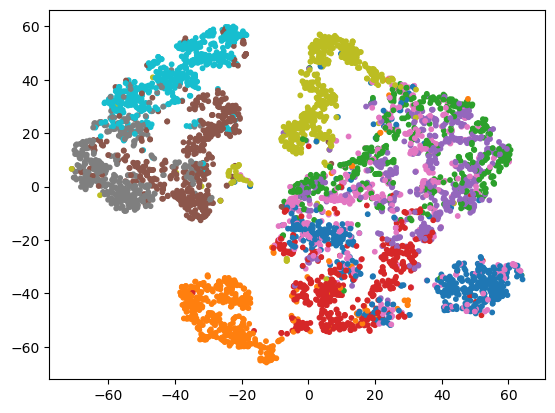

In [10]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

We will make the figure prettier (adapt from this [Scikit-learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)).

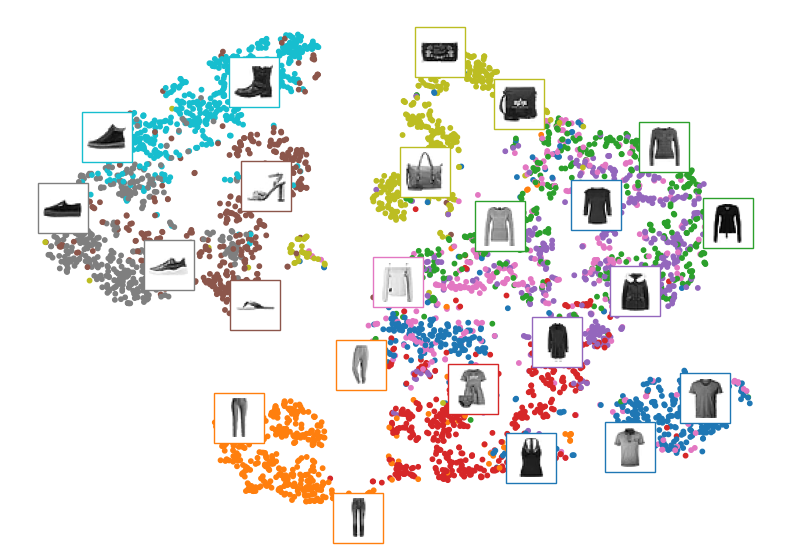

In [23]:
from matplotlib import offsetbox

plt.figure(figsize=(10, 7))
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap="tab10")
image_positions = np.array([[1.0, 1.0]])
for idx, position in enumerate(Z):
    distance = np.sum((position - image_positions) ** 2, 1)
    if np.min(distance) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(X_valid[idx], cmap="binary"),
            position,
            bboxprops={"edgecolor": plt.cm.tab10(y_valid[idx])},
        )
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

## Tying Weights

In [7]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            name="bias", shape=self.dense.input_shape[-1], initializer="zeros"
        )
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [12]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

encoder = tf.keras.Sequential([tf.keras.layers.Flatten(), dense_1, dense_2])

decoder = tf.keras.Sequential(
    [
        DenseTranspose(dense_2, activation="relu"),
        DenseTranspose(dense_1),
        tf.keras.layers.Reshape([28, 28]),
    ]
)

tied_ae = tf.keras.Sequential([encoder, decoder])

tied_ae.compile(loss="mse", optimizer="nadam")
tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.0223 - val_loss: 0.0165
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 6/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 8/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 9/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 10/10
1719/1719 [==============================] - 14s 8ms/step 

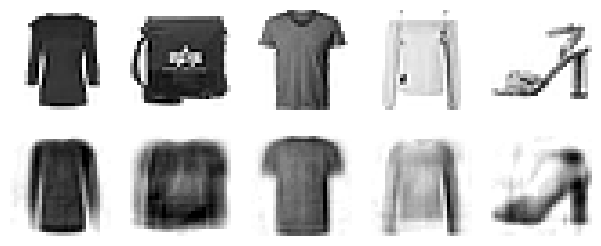

In [14]:
plot_reconstruction(tied_ae)

## Extra Material - Training one Autoencoder at a Time

In [2]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10, output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(
        X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid)
    )
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [5]:
X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat
)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu"
)

Epoch 1/10


2024-04-06 19:34:37.122996: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1719/1719 [==============================] - 11s 6ms/step - loss: 0.0189 - val_loss: 0.0129
Epoch 2/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 5/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 6/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 7/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 8/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 9/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 10/10
1719/1719 [==============================] - 21s 12ms/step - loss

In [12]:
stacked_ae_1_by_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(),
        enc1,
        enc2,
        dec2,
        dec1,
        tf.keras.layers.Reshape([28, 28]),
    ]
)

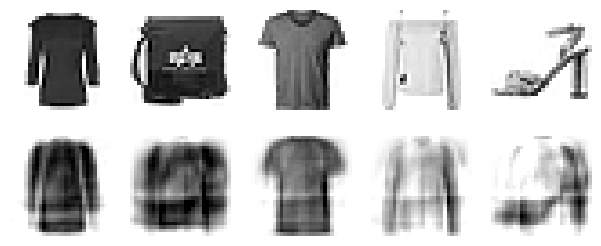

In [14]:
plot_reconstruction(stacked_ae_1_by_1)

You can continue to train this full stacked autoencoder for a few epochs.

In [15]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
stacked_ae_1_by_1.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 25s 14ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 3/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 4/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0137 - val_loss: 0.0137


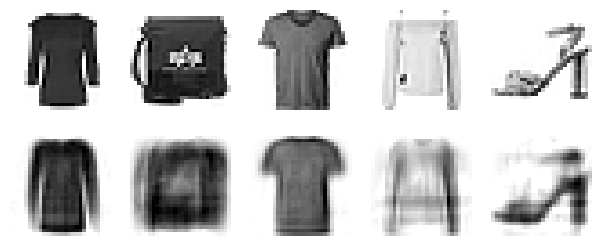

In [16]:
plot_reconstruction(stacked_ae_1_by_1)

## Convolutional Autoencoders

In [10]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape([28, 28, 1]),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(2),  # output: (14, 14, 16)
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(2),  # output: (7, 7, 32)
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(2),  # output: (3, 3, 64)
        tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
        tf.keras.layers.GlobalAvgPool2D(),  # output: 30
    ]
)

conv_decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3 * 3 * 16),
        tf.keras.layers.Reshape([3, 3, 16]),
        tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
        tf.keras.layers.Conv2DTranspose(
            16, 3, strides=2, padding="same", activation="relu"
        ),
        tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
        tf.keras.layers.Reshape([28, 28]),
    ]
)
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [12]:
conv_ae.compile(loss="mse", optimizer="nadam")
for i in range(10):
    conv_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))
    if i < 9:
        from time import sleep

        sleep(100)

1719/1719 [==============================] - 113s 66ms/step - loss: 0.0123 - val_loss: 0.0134


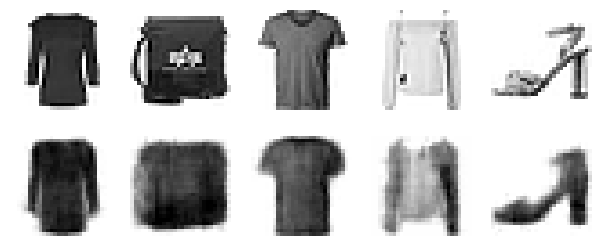

In [14]:
plot_reconstruction(conv_ae)

# Extra Material - Recurrent Autoencoders

We can treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions.

In [15]:
tf.random.set_seed(42)
recurrent_encoder = tf.keras.Sequential(
    [tf.keras.layers.LSTM(100, return_sequences=True), tf.keras.layers.LSTM(30)]
)

recurrent_decoder = tf.keras.Sequential(
    [
        tf.keras.layers.RepeatVector(28),
        tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.Dense(28),
    ]
)
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [16]:
for i in range(10):
    recurrent_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))
    if i < 9:
        from time import sleep

        sleep(100)

2024-04-06 22:32:15.634945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-06 22:32:15.635745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-06 22:32:15.636636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1718/1719 [============================>.] - ETA: 0s - loss: 0.0263

2024-04-06 22:34:20.246540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-06 22:34:20.247428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-06 22:34:20.248481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1719/1719 [==============================] - 78s 45ms/step - loss: 0.0107 - val_loss: 0.0108


2024-04-06 23:03:02.425740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-06 23:03:02.426791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-06 23:03:02.428000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

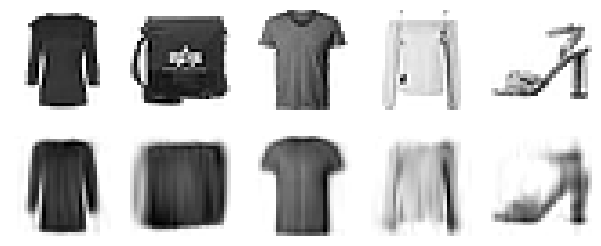

In [17]:
plot_reconstruction(recurrent_ae)

# Denoising Autoencoders

In [7]:
tf.random.set_seed(42)
dropout_encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
    ]
)

dropout_decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(28 * 28),
        tf.keras.layers.Reshape([28, 28]),
    ]
)

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="mse", optimizer="nadam")

In [8]:
for i in range(10):
    history = dropout_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))
    if i < 9:
        from time import sleep

        sleep(10)

1719/1719 [==============================] - 17s 10ms/step - loss: 0.0192 - val_loss: 0.0179


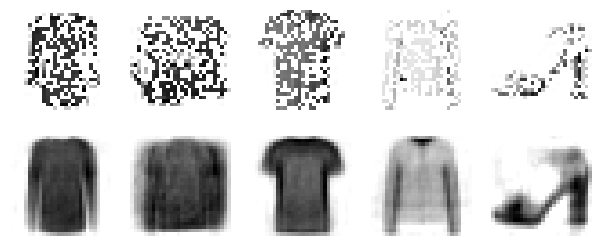

In [9]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstruction(dropout_ae, dropout(X_valid, training=True))